<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[03:09:05] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


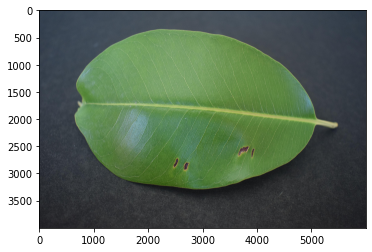

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

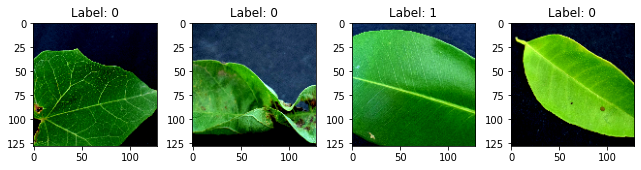

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[03:09:11] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[03:09:13] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.212348788046194 samples/sec                   batch loss = 0.1786898970603943 | accuracy = 0.8


Epoch[1] Batch[10] Speed: 1.2662024965083087 samples/sec                   batch loss = 1.2698304653167725 | accuracy = 0.675


Epoch[1] Batch[15] Speed: 1.2654280560576583 samples/sec                   batch loss = 0.42105308175086975 | accuracy = 0.65


Epoch[1] Batch[20] Speed: 1.2562568490650452 samples/sec                   batch loss = 0.25064989924430847 | accuracy = 0.6875


Epoch[1] Batch[25] Speed: 1.2572625706278409 samples/sec                   batch loss = 0.2459772527217865 | accuracy = 0.66


Epoch[1] Batch[30] Speed: 1.2530103565271573 samples/sec                   batch loss = 0.8394569158554077 | accuracy = 0.6916666666666667


Epoch[1] Batch[35] Speed: 1.2588770813936807 samples/sec                   batch loss = 1.0270915031433105 | accuracy = 0.6928571428571428


Epoch[1] Batch[40] Speed: 1.2565888049018392 samples/sec                   batch loss = 0.6728530526161194 | accuracy = 0.6875


Epoch[1] Batch[45] Speed: 1.2312474951734502 samples/sec                   batch loss = 0.8088604211807251 | accuracy = 0.6611111111111111


Epoch[1] Batch[50] Speed: 1.2259400220018948 samples/sec                   batch loss = 0.5695357322692871 | accuracy = 0.66


Epoch[1] Batch[55] Speed: 1.2210131199907777 samples/sec                   batch loss = 0.6827555894851685 | accuracy = 0.6454545454545455


Epoch[1] Batch[60] Speed: 1.2243901627351723 samples/sec                   batch loss = 0.3966033160686493 | accuracy = 0.65


Epoch[1] Batch[65] Speed: 1.2227115175507897 samples/sec                   batch loss = 1.0644663572311401 | accuracy = 0.6346153846153846


Epoch[1] Batch[70] Speed: 1.219454234930427 samples/sec                   batch loss = 0.6277579665184021 | accuracy = 0.6357142857142857


Epoch[1] Batch[75] Speed: 1.224689844008627 samples/sec                   batch loss = 0.9376460313796997 | accuracy = 0.6433333333333333


Epoch[1] Batch[80] Speed: 1.2299660955417033 samples/sec                   batch loss = 0.3405512571334839 | accuracy = 0.640625


Epoch[1] Batch[85] Speed: 1.228476475201709 samples/sec                   batch loss = 0.271396666765213 | accuracy = 0.65


Epoch[1] Batch[90] Speed: 1.228531168826509 samples/sec                   batch loss = 0.5981522798538208 | accuracy = 0.6416666666666667


Epoch[1] Batch[95] Speed: 1.2574891105708224 samples/sec                   batch loss = 0.34936195611953735 | accuracy = 0.6447368421052632


Epoch[1] Batch[100] Speed: 1.259614298859522 samples/sec                   batch loss = 0.861600399017334 | accuracy = 0.6475


Epoch[1] Batch[105] Speed: 1.2640661811535636 samples/sec                   batch loss = 1.0354936122894287 | accuracy = 0.6452380952380953


Epoch[1] Batch[110] Speed: 1.2686051821366782 samples/sec                   batch loss = 0.770991325378418 | accuracy = 0.6454545454545455


Epoch[1] Batch[115] Speed: 1.263226436202277 samples/sec                   batch loss = 0.985622763633728 | accuracy = 0.6478260869565218


Epoch[1] Batch[120] Speed: 1.2646222467382897 samples/sec                   batch loss = 0.37060117721557617 | accuracy = 0.6541666666666667


Epoch[1] Batch[125] Speed: 1.262217896765944 samples/sec                   batch loss = 0.6608304381370544 | accuracy = 0.654


Epoch[1] Batch[130] Speed: 1.2617729678718699 samples/sec                   batch loss = 0.601367175579071 | accuracy = 0.6538461538461539


Epoch[1] Batch[135] Speed: 1.2749934871827453 samples/sec                   batch loss = 0.49881041049957275 | accuracy = 0.6592592592592592


Epoch[1] Batch[140] Speed: 1.264913814389463 samples/sec                   batch loss = 0.9276769757270813 | accuracy = 0.6625


Epoch[1] Batch[145] Speed: 1.2643815044401248 samples/sec                   batch loss = 0.23409084975719452 | accuracy = 0.6672413793103448


Epoch[1] Batch[150] Speed: 1.2689738341523908 samples/sec                   batch loss = 0.44441676139831543 | accuracy = 0.67


Epoch[1] Batch[155] Speed: 1.2639548553111637 samples/sec                   batch loss = 1.5734139680862427 | accuracy = 0.6725806451612903


Epoch[1] Batch[160] Speed: 1.2658186437286612 samples/sec                   batch loss = 0.553413987159729 | accuracy = 0.675


Epoch[1] Batch[165] Speed: 1.2685793787617579 samples/sec                   batch loss = 0.4201272428035736 | accuracy = 0.6712121212121213


Epoch[1] Batch[170] Speed: 1.2631959054819075 samples/sec                   batch loss = 0.18398095667362213 | accuracy = 0.6705882352941176


Epoch[1] Batch[175] Speed: 1.2645895514906769 samples/sec                   batch loss = 1.6934254169464111 | accuracy = 0.6657142857142857


Epoch[1] Batch[180] Speed: 1.2584312948639007 samples/sec                   batch loss = 0.4497291147708893 | accuracy = 0.6666666666666666


Epoch[1] Batch[185] Speed: 1.2681949465005806 samples/sec                   batch loss = 1.57500159740448 | accuracy = 0.6635135135135135


Epoch[1] Batch[190] Speed: 1.264358159410021 samples/sec                   batch loss = 0.4239450991153717 | accuracy = 0.6631578947368421


Epoch[1] Batch[195] Speed: 1.2615034292570888 samples/sec                   batch loss = 0.6652472615242004 | accuracy = 0.6615384615384615


Epoch[1] Batch[200] Speed: 1.263200660948794 samples/sec                   batch loss = 1.193501353263855 | accuracy = 0.66125


Epoch[1] Batch[205] Speed: 1.2619441813704175 samples/sec                   batch loss = 0.9842889308929443 | accuracy = 0.6585365853658537


Epoch[1] Batch[210] Speed: 1.2708589144336717 samples/sec                   batch loss = 0.6181588172912598 | accuracy = 0.6571428571428571


Epoch[1] Batch[215] Speed: 1.2646700058087987 samples/sec                   batch loss = 0.44496482610702515 | accuracy = 0.6581395348837209


Epoch[1] Batch[220] Speed: 1.2682543845001155 samples/sec                   batch loss = 0.8170046806335449 | accuracy = 0.6556818181818181


Epoch[1] Batch[225] Speed: 1.2663727157823546 samples/sec                   batch loss = 0.5033765435218811 | accuracy = 0.6566666666666666


Epoch[1] Batch[230] Speed: 1.265415743720294 samples/sec                   batch loss = 0.6399766206741333 | accuracy = 0.657608695652174


Epoch[1] Batch[235] Speed: 1.264221155753176 samples/sec                   batch loss = 0.555743396282196 | accuracy = 0.6563829787234042


Epoch[1] Batch[240] Speed: 1.260912763727065 samples/sec                   batch loss = 0.6628038287162781 | accuracy = 0.6572916666666667


Epoch[1] Batch[245] Speed: 1.2642413519228248 samples/sec                   batch loss = 1.0059109926223755 | accuracy = 0.6602040816326531


Epoch[1] Batch[250] Speed: 1.26135006851741 samples/sec                   batch loss = 0.48958614468574524 | accuracy = 0.659


Epoch[1] Batch[255] Speed: 1.271363261704602 samples/sec                   batch loss = 0.37941256165504456 | accuracy = 0.6568627450980392


Epoch[1] Batch[260] Speed: 1.2578350146860486 samples/sec                   batch loss = 0.34067991375923157 | accuracy = 0.6586538461538461


Epoch[1] Batch[265] Speed: 1.2653616295433587 samples/sec                   batch loss = 1.2104665040969849 | accuracy = 0.6584905660377358


Epoch[1] Batch[270] Speed: 1.2581672390727703 samples/sec                   batch loss = 0.8412678837776184 | accuracy = 0.6583333333333333


Epoch[1] Batch[275] Speed: 1.2639596164941103 samples/sec                   batch loss = 2.204056978225708 | accuracy = 0.6572727272727272


Epoch[1] Batch[280] Speed: 1.264271456845169 samples/sec                   batch loss = 0.7138224840164185 | accuracy = 0.6571428571428571


Epoch[1] Batch[285] Speed: 1.2673489428948697 samples/sec                   batch loss = 0.2767489552497864 | accuracy = 0.6605263157894737


Epoch[1] Batch[290] Speed: 1.2670233347697328 samples/sec                   batch loss = 1.278586745262146 | accuracy = 0.6629310344827586


Epoch[1] Batch[295] Speed: 1.2699628250930886 samples/sec                   batch loss = 1.662185788154602 | accuracy = 0.6635593220338983


Epoch[1] Batch[300] Speed: 1.267124578864178 samples/sec                   batch loss = 0.5028427839279175 | accuracy = 0.6641666666666667


Epoch[1] Batch[305] Speed: 1.2686157340050197 samples/sec                   batch loss = 1.4674251079559326 | accuracy = 0.6631147540983606


Epoch[1] Batch[310] Speed: 1.2677561405698807 samples/sec                   batch loss = 0.3663491904735565 | accuracy = 0.6637096774193548


Epoch[1] Batch[315] Speed: 1.2609088783541853 samples/sec                   batch loss = 0.4016307592391968 | accuracy = 0.6666666666666666


Epoch[1] Batch[320] Speed: 1.2679299400074395 samples/sec                   batch loss = 0.301402747631073 | accuracy = 0.66875


Epoch[1] Batch[325] Speed: 1.2647957600147097 samples/sec                   batch loss = 0.26040923595428467 | accuracy = 0.6692307692307692


Epoch[1] Batch[330] Speed: 1.2627241509725078 samples/sec                   batch loss = 0.5633116960525513 | accuracy = 0.6696969696969697


Epoch[1] Batch[335] Speed: 1.2697349400945905 samples/sec                   batch loss = 0.2782581150531769 | accuracy = 0.673134328358209


Epoch[1] Batch[340] Speed: 1.2730191403403395 samples/sec                   batch loss = 1.169264316558838 | accuracy = 0.674264705882353


Epoch[1] Batch[345] Speed: 1.2636769596099335 samples/sec                   batch loss = 0.8209918737411499 | accuracy = 0.672463768115942


Epoch[1] Batch[350] Speed: 1.2634483751639536 samples/sec                   batch loss = 0.4621535539627075 | accuracy = 0.6735714285714286


Epoch[1] Batch[355] Speed: 1.2654313012097282 samples/sec                   batch loss = 0.7806240320205688 | accuracy = 0.6725352112676056


Epoch[1] Batch[360] Speed: 1.263560182784201 samples/sec                   batch loss = 0.40212658047676086 | accuracy = 0.6736111111111112


Epoch[1] Batch[365] Speed: 1.264769062565421 samples/sec                   batch loss = 0.6935446262359619 | accuracy = 0.673972602739726


Epoch[1] Batch[370] Speed: 1.2632749459894228 samples/sec                   batch loss = 0.7254090905189514 | accuracy = 0.6743243243243243


Epoch[1] Batch[375] Speed: 1.2648387643475214 samples/sec                   batch loss = 1.4759093523025513 | accuracy = 0.6746666666666666


Epoch[1] Batch[380] Speed: 1.2672769539698183 samples/sec                   batch loss = 0.3319042921066284 | accuracy = 0.6743421052631579


Epoch[1] Batch[385] Speed: 1.2652711632675024 samples/sec                   batch loss = 0.6087044477462769 | accuracy = 0.674025974025974


Epoch[1] Batch[390] Speed: 1.2629235720893344 samples/sec                   batch loss = 0.400078147649765 | accuracy = 0.6756410256410257


Epoch[1] Batch[395] Speed: 1.2617445000658427 samples/sec                   batch loss = 0.4720308184623718 | accuracy = 0.6765822784810127


Epoch[1] Batch[400] Speed: 1.2637207445860956 samples/sec                   batch loss = 0.21390309929847717 | accuracy = 0.678125


Epoch[1] Batch[405] Speed: 1.267801837348189 samples/sec                   batch loss = 0.2176247090101242 | accuracy = 0.678395061728395


Epoch[1] Batch[410] Speed: 1.248613477871054 samples/sec                   batch loss = 0.38082489371299744 | accuracy = 0.6792682926829269


Epoch[1] Batch[415] Speed: 1.2242770495193513 samples/sec                   batch loss = 0.35390159487724304 | accuracy = 0.6789156626506024


Epoch[1] Batch[420] Speed: 1.2275681760943888 samples/sec                   batch loss = 0.25894859433174133 | accuracy = 0.6803571428571429


Epoch[1] Batch[425] Speed: 1.2246000046714782 samples/sec                   batch loss = 0.7275943160057068 | accuracy = 0.6811764705882353


Epoch[1] Batch[430] Speed: 1.2269797802888314 samples/sec                   batch loss = 0.32218942046165466 | accuracy = 0.6813953488372093


Epoch[1] Batch[435] Speed: 1.2524917561093927 samples/sec                   batch loss = 0.9912294149398804 | accuracy = 0.6816091954022988


Epoch[1] Batch[440] Speed: 1.2522570117503293 samples/sec                   batch loss = 0.41669961810112 | accuracy = 0.6823863636363636


Epoch[1] Batch[445] Speed: 1.2500607996948094 samples/sec                   batch loss = 0.4618987441062927 | accuracy = 0.6842696629213483


Epoch[1] Batch[450] Speed: 1.2338685911934968 samples/sec                   batch loss = 0.5547491908073425 | accuracy = 0.685


Epoch[1] Batch[455] Speed: 1.2278838835087884 samples/sec                   batch loss = 0.38611456751823425 | accuracy = 0.6862637362637363


Epoch[1] Batch[460] Speed: 1.2248005298907856 samples/sec                   batch loss = 0.18184679746627808 | accuracy = 0.6880434782608695


Epoch[1] Batch[465] Speed: 1.2643449150619395 samples/sec                   batch loss = 0.5513487458229065 | accuracy = 0.6881720430107527


Epoch[1] Batch[470] Speed: 1.2674992652874975 samples/sec                   batch loss = 0.4646584093570709 | accuracy = 0.6877659574468085


Epoch[1] Batch[475] Speed: 1.2696058960050496 samples/sec                   batch loss = 0.6918884515762329 | accuracy = 0.6878947368421052


Epoch[1] Batch[480] Speed: 1.2648904496986906 samples/sec                   batch loss = 0.4068760871887207 | accuracy = 0.6885416666666667


Epoch[1] Batch[485] Speed: 1.2635436244926534 samples/sec                   batch loss = 0.5368762016296387 | accuracy = 0.688659793814433


Epoch[1] Batch[490] Speed: 1.271260086902545 samples/sec                   batch loss = 0.30240678787231445 | accuracy = 0.6887755102040817


Epoch[1] Batch[495] Speed: 1.2657369927903637 samples/sec                   batch loss = 0.8041076064109802 | accuracy = 0.6883838383838384


Epoch[1] Batch[500] Speed: 1.2632206343007157 samples/sec                   batch loss = 0.5982165932655334 | accuracy = 0.6885


Epoch[1] Batch[505] Speed: 1.2396481622786948 samples/sec                   batch loss = 0.4708702862262726 | accuracy = 0.6886138613861386


Epoch[1] Batch[510] Speed: 1.222755094060994 samples/sec                   batch loss = 0.4561581313610077 | accuracy = 0.6897058823529412


Epoch[1] Batch[515] Speed: 1.2261970853472468 samples/sec                   batch loss = 0.4787428379058838 | accuracy = 0.6878640776699029


Epoch[1] Batch[520] Speed: 1.2654381733514084 samples/sec                   batch loss = 0.5819027423858643 | accuracy = 0.6865384615384615


Epoch[1] Batch[525] Speed: 1.2608253960046996 samples/sec                   batch loss = 0.3058645725250244 | accuracy = 0.6876190476190476


Epoch[1] Batch[530] Speed: 1.2643591122515174 samples/sec                   batch loss = 0.6426325440406799 | accuracy = 0.6867924528301886


Epoch[1] Batch[535] Speed: 1.257602505427965 samples/sec                   batch loss = 0.7198216319084167 | accuracy = 0.6873831775700935


Epoch[1] Batch[540] Speed: 1.2589655019228299 samples/sec                   batch loss = 0.3741638958454132 | accuracy = 0.687962962962963


Epoch[1] Batch[545] Speed: 1.2558953598194564 samples/sec                   batch loss = 0.35340410470962524 | accuracy = 0.6894495412844037


Epoch[1] Batch[550] Speed: 1.261789384890671 samples/sec                   batch loss = 0.5077242851257324 | accuracy = 0.69


Epoch[1] Batch[555] Speed: 1.2696289548258712 samples/sec                   batch loss = 0.5972678065299988 | accuracy = 0.690990990990991


Epoch[1] Batch[560] Speed: 1.2660480867201211 samples/sec                   batch loss = 0.7357339262962341 | accuracy = 0.6915178571428572


Epoch[1] Batch[565] Speed: 1.2653801442787822 samples/sec                   batch loss = 0.7243330478668213 | accuracy = 0.6915929203539823


Epoch[1] Batch[570] Speed: 1.2670751988157904 samples/sec                   batch loss = 0.22917503118515015 | accuracy = 0.6938596491228071


Epoch[1] Batch[575] Speed: 1.2620820211106585 samples/sec                   batch loss = 0.367145299911499 | accuracy = 0.6956521739130435


Epoch[1] Batch[580] Speed: 1.2662067968248407 samples/sec                   batch loss = 0.9237644672393799 | accuracy = 0.696551724137931


Epoch[1] Batch[585] Speed: 1.266142772909799 samples/sec                   batch loss = 0.4918327033519745 | accuracy = 0.6974358974358974


Epoch[1] Batch[590] Speed: 1.261498307146258 samples/sec                   batch loss = 1.0734764337539673 | accuracy = 0.6966101694915254


Epoch[1] Batch[595] Speed: 1.263010280035066 samples/sec                   batch loss = 0.5383089780807495 | accuracy = 0.6974789915966386


Epoch[1] Batch[600] Speed: 1.270857566705339 samples/sec                   batch loss = 1.0890138149261475 | accuracy = 0.6966666666666667


Epoch[1] Batch[605] Speed: 1.26290332293536 samples/sec                   batch loss = 0.9233496785163879 | accuracy = 0.6966942148760331


Epoch[1] Batch[610] Speed: 1.2589385776901127 samples/sec                   batch loss = 0.7020059823989868 | accuracy = 0.6959016393442623


Epoch[1] Batch[615] Speed: 1.2605421501174647 samples/sec                   batch loss = 1.1523315906524658 | accuracy = 0.6959349593495935


Epoch[1] Batch[620] Speed: 1.2596992288130058 samples/sec                   batch loss = 0.9695417881011963 | accuracy = 0.6959677419354838


Epoch[1] Batch[625] Speed: 1.2677634211776712 samples/sec                   batch loss = 0.6637925505638123 | accuracy = 0.6976


Epoch[1] Batch[630] Speed: 1.2685425460229205 samples/sec                   batch loss = 0.4170098304748535 | accuracy = 0.696031746031746


Epoch[1] Batch[635] Speed: 1.2659367936166277 samples/sec                   batch loss = 0.31243622303009033 | accuracy = 0.6968503937007874


Epoch[1] Batch[640] Speed: 1.2602450208681029 samples/sec                   batch loss = 0.6993775367736816 | accuracy = 0.696484375


Epoch[1] Batch[645] Speed: 1.2650438141232176 samples/sec                   batch loss = 0.384621262550354 | accuracy = 0.6968992248062016


Epoch[1] Batch[650] Speed: 1.259430386270141 samples/sec                   batch loss = 0.45357152819633484 | accuracy = 0.6961538461538461


Epoch[1] Batch[655] Speed: 1.2659589551464527 samples/sec                   batch loss = 0.7402196526527405 | accuracy = 0.6961832061068702


Epoch[1] Batch[660] Speed: 1.2678858628729983 samples/sec                   batch loss = 0.655656099319458 | accuracy = 0.6958333333333333


Epoch[1] Batch[665] Speed: 1.2618805877849395 samples/sec                   batch loss = 0.3857666850090027 | accuracy = 0.6954887218045113


Epoch[1] Batch[670] Speed: 1.266136084217606 samples/sec                   batch loss = 0.8251644372940063 | accuracy = 0.6951492537313433


Epoch[1] Batch[675] Speed: 1.261265389915961 samples/sec                   batch loss = 0.7738614082336426 | accuracy = 0.6955555555555556


Epoch[1] Batch[680] Speed: 1.2614099098611407 samples/sec                   batch loss = 0.672932505607605 | accuracy = 0.6966911764705882


Epoch[1] Batch[685] Speed: 1.266557514272652 samples/sec                   batch loss = 0.23542487621307373 | accuracy = 0.6981751824817518


Epoch[1] Batch[690] Speed: 1.2598298617058479 samples/sec                   batch loss = 0.4778907001018524 | accuracy = 0.697463768115942


Epoch[1] Batch[695] Speed: 1.26593096679149 samples/sec                   batch loss = 0.24074171483516693 | accuracy = 0.6982014388489208


Epoch[1] Batch[700] Speed: 1.2661129609976272 samples/sec                   batch loss = 0.2752370834350586 | accuracy = 0.6982142857142857


Epoch[1] Batch[705] Speed: 1.2657514122486524 samples/sec                   batch loss = 1.0051809549331665 | accuracy = 0.6971631205673758


Epoch[1] Batch[710] Speed: 1.2666131651483157 samples/sec                   batch loss = 0.31830596923828125 | accuracy = 0.6978873239436619


Epoch[1] Batch[715] Speed: 1.2624044292315437 samples/sec                   batch loss = 0.199582040309906 | accuracy = 0.6982517482517483


Epoch[1] Batch[720] Speed: 1.2618456614977314 samples/sec                   batch loss = 0.9500507116317749 | accuracy = 0.6986111111111111


Epoch[1] Batch[725] Speed: 1.259998182537793 samples/sec                   batch loss = 0.5960111618041992 | accuracy = 0.7


Epoch[1] Batch[730] Speed: 1.2668111383107086 samples/sec                   batch loss = 0.36159220337867737 | accuracy = 0.7006849315068493


Epoch[1] Batch[735] Speed: 1.262467505632006 samples/sec                   batch loss = 0.3406480550765991 | accuracy = 0.7010204081632653


Epoch[1] Batch[740] Speed: 1.2646610447501978 samples/sec                   batch loss = 0.6431518197059631 | accuracy = 0.6993243243243243


Epoch[1] Batch[745] Speed: 1.2681999314090837 samples/sec                   batch loss = 0.44839975237846375 | accuracy = 0.7


Epoch[1] Batch[750] Speed: 1.2630574419866447 samples/sec                   batch loss = 0.4481194019317627 | accuracy = 0.7


Epoch[1] Batch[755] Speed: 1.2648310405157628 samples/sec                   batch loss = 0.7986360192298889 | accuracy = 0.6990066225165563


Epoch[1] Batch[760] Speed: 1.2619362080918577 samples/sec                   batch loss = 0.6355656385421753 | accuracy = 0.6980263157894737


Epoch[1] Batch[765] Speed: 1.2647201519483993 samples/sec                   batch loss = 0.5435426831245422 | accuracy = 0.6986928104575163


Epoch[1] Batch[770] Speed: 1.2613990981680212 samples/sec                   batch loss = 0.40348267555236816 | accuracy = 0.6983766233766234


Epoch[1] Batch[775] Speed: 1.2614736457134057 samples/sec                   batch loss = 0.8842884302139282 | accuracy = 0.6987096774193549


Epoch[1] Batch[780] Speed: 1.2648191212074196 samples/sec                   batch loss = 0.6219189763069153 | accuracy = 0.6977564102564102


Epoch[1] Batch[785] Speed: 1.2603518121953488 samples/sec                   batch loss = 0.4949198365211487 | accuracy = 0.6987261146496815


[Epoch 1] training: accuracy=0.6989213197969543
[Epoch 1] time cost: 653.0448241233826
[Epoch 1] validation: validation accuracy=0.7177777777777777


Epoch[2] Batch[5] Speed: 1.268598755175615 samples/sec                   batch loss = 0.5087005496025085 | accuracy = 0.9


Epoch[2] Batch[10] Speed: 1.2643999905041219 samples/sec                   batch loss = 0.3509168028831482 | accuracy = 0.875


Epoch[2] Batch[15] Speed: 1.275280842080427 samples/sec                   batch loss = 0.7903529405593872 | accuracy = 0.8166666666666667


Epoch[2] Batch[20] Speed: 1.2693989805745944 samples/sec                   batch loss = 0.6061276793479919 | accuracy = 0.775


Epoch[2] Batch[25] Speed: 1.2714493980340191 samples/sec                   batch loss = 0.3684626519680023 | accuracy = 0.79


Epoch[2] Batch[30] Speed: 1.2705544967106641 samples/sec                   batch loss = 0.4468294382095337 | accuracy = 0.8083333333333333


Epoch[2] Batch[35] Speed: 1.2683837293343132 samples/sec                   batch loss = 0.13241679966449738 | accuracy = 0.8142857142857143


Epoch[2] Batch[40] Speed: 1.271192661440223 samples/sec                   batch loss = 0.34758296608924866 | accuracy = 0.8


Epoch[2] Batch[45] Speed: 1.2708472663046348 samples/sec                   batch loss = 0.5566585659980774 | accuracy = 0.8055555555555556


Epoch[2] Batch[50] Speed: 1.2694765899711506 samples/sec                   batch loss = 0.4881371259689331 | accuracy = 0.805


Epoch[2] Batch[55] Speed: 1.2723236576198897 samples/sec                   batch loss = 0.24649600684642792 | accuracy = 0.8045454545454546


Epoch[2] Batch[60] Speed: 1.268998597743213 samples/sec                   batch loss = 0.1863851547241211 | accuracy = 0.8125


Epoch[2] Batch[65] Speed: 1.2694511353485192 samples/sec                   batch loss = 0.46497413516044617 | accuracy = 0.8076923076923077


Epoch[2] Batch[70] Speed: 1.2674834653973612 samples/sec                   batch loss = 0.7055628299713135 | accuracy = 0.8035714285714286


Epoch[2] Batch[75] Speed: 1.278020448978031 samples/sec                   batch loss = 0.696134626865387 | accuracy = 0.7966666666666666


Epoch[2] Batch[80] Speed: 1.2706988435554842 samples/sec                   batch loss = 0.6172283887863159 | accuracy = 0.796875


Epoch[2] Batch[85] Speed: 1.2658612400949538 samples/sec                   batch loss = 0.6228972673416138 | accuracy = 0.7941176470588235


Epoch[2] Batch[90] Speed: 1.274526533201038 samples/sec                   batch loss = 0.677391529083252 | accuracy = 0.7888888888888889


Epoch[2] Batch[95] Speed: 1.2679212201572467 samples/sec                   batch loss = 0.3224145770072937 | accuracy = 0.7894736842105263


Epoch[2] Batch[100] Speed: 1.2718934646577826 samples/sec                   batch loss = 0.7430614829063416 | accuracy = 0.7925


Epoch[2] Batch[105] Speed: 1.2686542977804922 samples/sec                   batch loss = 0.345492422580719 | accuracy = 0.7952380952380952


Epoch[2] Batch[110] Speed: 1.2705608472820973 samples/sec                   batch loss = 0.49632877111434937 | accuracy = 0.7909090909090909


Epoch[2] Batch[115] Speed: 1.267001135959094 samples/sec                   batch loss = 0.31965184211730957 | accuracy = 0.7913043478260869


Epoch[2] Batch[120] Speed: 1.2707433089905464 samples/sec                   batch loss = 0.45989224314689636 | accuracy = 0.7854166666666667


Epoch[2] Batch[125] Speed: 1.2747342520642269 samples/sec                   batch loss = 0.7450923919677734 | accuracy = 0.784


Epoch[2] Batch[130] Speed: 1.269844018659057 samples/sec                   batch loss = 0.11554930359125137 | accuracy = 0.7826923076923077


Epoch[2] Batch[135] Speed: 1.2710400173581058 samples/sec                   batch loss = 0.6861986517906189 | accuracy = 0.7796296296296297


Epoch[2] Batch[140] Speed: 1.2677537456513857 samples/sec                   batch loss = 0.1667737513780594 | accuracy = 0.7803571428571429


Epoch[2] Batch[145] Speed: 1.269930429872388 samples/sec                   batch loss = 0.47042107582092285 | accuracy = 0.7775862068965518


Epoch[2] Batch[150] Speed: 1.275515086076963 samples/sec                   batch loss = 0.10181186348199844 | accuracy = 0.78


Epoch[2] Batch[155] Speed: 1.2752080461802247 samples/sec                   batch loss = 0.31423527002334595 | accuracy = 0.7741935483870968


Epoch[2] Batch[160] Speed: 1.2721630246410642 samples/sec                   batch loss = 0.3944513499736786 | accuracy = 0.7765625


Epoch[2] Batch[165] Speed: 1.2679957739560785 samples/sec                   batch loss = 0.5610907673835754 | accuracy = 0.7787878787878788


Epoch[2] Batch[170] Speed: 1.268238757518472 samples/sec                   batch loss = 1.2944011688232422 | accuracy = 0.7779411764705882


Epoch[2] Batch[175] Speed: 1.2709309257897101 samples/sec                   batch loss = 0.44640377163887024 | accuracy = 0.7785714285714286


Epoch[2] Batch[180] Speed: 1.2666647087233396 samples/sec                   batch loss = 0.2580382525920868 | accuracy = 0.7791666666666667


Epoch[2] Batch[185] Speed: 1.2645457062905987 samples/sec                   batch loss = 0.27026546001434326 | accuracy = 0.7756756756756756


Epoch[2] Batch[190] Speed: 1.2691427832683488 samples/sec                   batch loss = 0.5093311667442322 | accuracy = 0.7763157894736842


Epoch[2] Batch[195] Speed: 1.2794066228591643 samples/sec                   batch loss = 0.26122957468032837 | accuracy = 0.7743589743589744


Epoch[2] Batch[200] Speed: 1.2657188495678904 samples/sec                   batch loss = 0.7241061925888062 | accuracy = 0.77625


Epoch[2] Batch[205] Speed: 1.2666850786766124 samples/sec                   batch loss = 0.44413670897483826 | accuracy = 0.776829268292683


Epoch[2] Batch[210] Speed: 1.2671690816235357 samples/sec                   batch loss = 0.4377126395702362 | accuracy = 0.7785714285714286


Epoch[2] Batch[215] Speed: 1.2664335126436779 samples/sec                   batch loss = 0.4655452072620392 | accuracy = 0.7779069767441861


Epoch[2] Batch[220] Speed: 1.2678953487800906 samples/sec                   batch loss = 0.3966429531574249 | accuracy = 0.7784090909090909


Epoch[2] Batch[225] Speed: 1.266979320644421 samples/sec                   batch loss = 0.5319154262542725 | accuracy = 0.7777777777777778


Epoch[2] Batch[230] Speed: 1.2671307994920666 samples/sec                   batch loss = 0.3404676914215088 | accuracy = 0.7815217391304348


Epoch[2] Batch[235] Speed: 1.2693259902971994 samples/sec                   batch loss = 0.5472768545150757 | accuracy = 0.7755319148936171


Epoch[2] Batch[240] Speed: 1.2705244766868917 samples/sec                   batch loss = 0.4901040196418762 | accuracy = 0.7739583333333333


Epoch[2] Batch[245] Speed: 1.2658365032910797 samples/sec                   batch loss = 0.3438725769519806 | accuracy = 0.7724489795918368


Epoch[2] Batch[250] Speed: 1.265860571519975 samples/sec                   batch loss = 0.1275498867034912 | accuracy = 0.771


Epoch[2] Batch[255] Speed: 1.263149113597256 samples/sec                   batch loss = 0.5776271224021912 | accuracy = 0.7715686274509804


Epoch[2] Batch[260] Speed: 1.2638214615469738 samples/sec                   batch loss = 0.6734431385993958 | accuracy = 0.7711538461538462


Epoch[2] Batch[265] Speed: 1.2668048251677813 samples/sec                   batch loss = 1.0232298374176025 | accuracy = 0.7716981132075472


Epoch[2] Batch[270] Speed: 1.2673738345855574 samples/sec                   batch loss = 0.34480559825897217 | accuracy = 0.7685185185185185


Epoch[2] Batch[275] Speed: 1.2724583697513001 samples/sec                   batch loss = 0.3746546804904938 | accuracy = 0.7718181818181818


Epoch[2] Batch[280] Speed: 1.266493263674207 samples/sec                   batch loss = 0.7385475039482117 | accuracy = 0.7714285714285715


Epoch[2] Batch[285] Speed: 1.2752619395498506 samples/sec                   batch loss = 0.3230634033679962 | accuracy = 0.7736842105263158


Epoch[2] Batch[290] Speed: 1.2671496531527429 samples/sec                   batch loss = 0.4903344511985779 | accuracy = 0.7724137931034483


Epoch[2] Batch[295] Speed: 1.275511595054725 samples/sec                   batch loss = 0.8146407604217529 | accuracy = 0.7728813559322034


Epoch[2] Batch[300] Speed: 1.2711716646853404 samples/sec                   batch loss = 0.6517714858055115 | accuracy = 0.7733333333333333


Epoch[2] Batch[305] Speed: 1.2706923953633087 samples/sec                   batch loss = 0.2262069433927536 | accuracy = 0.771311475409836


Epoch[2] Batch[310] Speed: 1.2684545973269876 samples/sec                   batch loss = 0.7245957851409912 | accuracy = 0.7669354838709678


Epoch[2] Batch[315] Speed: 1.2703729549507636 samples/sec                   batch loss = 0.4100244343280792 | accuracy = 0.7658730158730159


Epoch[2] Batch[320] Speed: 1.2697519493510439 samples/sec                   batch loss = 0.18613135814666748 | accuracy = 0.76484375


Epoch[2] Batch[325] Speed: 1.2694474853353728 samples/sec                   batch loss = 0.4709996283054352 | accuracy = 0.7623076923076924


Epoch[2] Batch[330] Speed: 1.2695517110729106 samples/sec                   batch loss = 0.5043662190437317 | accuracy = 0.7606060606060606


Epoch[2] Batch[335] Speed: 1.2706243564882083 samples/sec                   batch loss = 0.5860965251922607 | accuracy = 0.758955223880597


Epoch[2] Batch[340] Speed: 1.267661308712545 samples/sec                   batch loss = 0.2170490026473999 | accuracy = 0.7610294117647058


Epoch[2] Batch[345] Speed: 1.268839378967199 samples/sec                   batch loss = 0.4161754846572876 | accuracy = 0.7601449275362319


Epoch[2] Batch[350] Speed: 1.265353708456062 samples/sec                   batch loss = 0.8571374416351318 | accuracy = 0.7585714285714286


Epoch[2] Batch[355] Speed: 1.2730253223838024 samples/sec                   batch loss = 0.09459540247917175 | accuracy = 0.7598591549295775


Epoch[2] Batch[360] Speed: 1.2663633482315486 samples/sec                   batch loss = 0.4470498561859131 | accuracy = 0.7611111111111111


Epoch[2] Batch[365] Speed: 1.268250741365676 samples/sec                   batch loss = 0.3443133234977722 | accuracy = 0.7616438356164383


Epoch[2] Batch[370] Speed: 1.268012640813005 samples/sec                   batch loss = 0.35384708642959595 | accuracy = 0.7628378378378379


Epoch[2] Batch[375] Speed: 1.2713437044100668 samples/sec                   batch loss = 0.36818769574165344 | accuracy = 0.7646666666666667


Epoch[2] Batch[380] Speed: 1.266025922069588 samples/sec                   batch loss = 0.49887263774871826 | accuracy = 0.7631578947368421


Epoch[2] Batch[385] Speed: 1.2720543189088664 samples/sec                   batch loss = 0.18484914302825928 | accuracy = 0.7642857142857142


Epoch[2] Batch[390] Speed: 1.2676279772478176 samples/sec                   batch loss = 0.45043233036994934 | accuracy = 0.7647435897435897


Epoch[2] Batch[395] Speed: 1.2692982369865884 samples/sec                   batch loss = 0.7934504151344299 | accuracy = 0.7651898734177215


Epoch[2] Batch[400] Speed: 1.278139135046837 samples/sec                   batch loss = 0.30834197998046875 | accuracy = 0.764375


Epoch[2] Batch[405] Speed: 1.2696743062836982 samples/sec                   batch loss = 0.40583187341690063 | accuracy = 0.7648148148148148


Epoch[2] Batch[410] Speed: 1.2704316352713987 samples/sec                   batch loss = 0.43201443552970886 | accuracy = 0.7652439024390244


Epoch[2] Batch[415] Speed: 1.2657781511864528 samples/sec                   batch loss = 0.6810108423233032 | accuracy = 0.7650602409638554


Epoch[2] Batch[420] Speed: 1.2705123536178768 samples/sec                   batch loss = 0.25395020842552185 | accuracy = 0.7654761904761904


Epoch[2] Batch[425] Speed: 1.2704500100600293 samples/sec                   batch loss = 0.6709824800491333 | accuracy = 0.7635294117647059


Epoch[2] Batch[430] Speed: 1.2686154462244639 samples/sec                   batch loss = 0.6867626905441284 | accuracy = 0.7627906976744186


Epoch[2] Batch[435] Speed: 1.2715813229338415 samples/sec                   batch loss = 0.6086320281028748 | accuracy = 0.7637931034482759


Epoch[2] Batch[440] Speed: 1.2741108146974465 samples/sec                   batch loss = 0.42857152223587036 | accuracy = 0.7642045454545454


Epoch[2] Batch[445] Speed: 1.2707314704863406 samples/sec                   batch loss = 0.2648659348487854 | accuracy = 0.7640449438202247


Epoch[2] Batch[450] Speed: 1.2685852299926677 samples/sec                   batch loss = 0.5212660431861877 | accuracy = 0.7638888888888888


Epoch[2] Batch[455] Speed: 1.2736893721377565 samples/sec                   batch loss = 0.560145378112793 | accuracy = 0.760989010989011


Epoch[2] Batch[460] Speed: 1.2664262473028307 samples/sec                   batch loss = 0.5437201261520386 | accuracy = 0.7581521739130435


Epoch[2] Batch[465] Speed: 1.2652918701236133 samples/sec                   batch loss = 0.9735538363456726 | accuracy = 0.7575268817204301


Epoch[2] Batch[470] Speed: 1.271296114295604 samples/sec                   batch loss = 0.9876582622528076 | accuracy = 0.7569148936170212


Epoch[2] Batch[475] Speed: 1.2616658407074322 samples/sec                   batch loss = 0.7372302412986755 | accuracy = 0.7547368421052632


Epoch[2] Batch[480] Speed: 1.2622160924950157 samples/sec                   batch loss = 0.5921823382377625 | accuracy = 0.7546875


Epoch[2] Batch[485] Speed: 1.2683692498392163 samples/sec                   batch loss = 0.3645745515823364 | accuracy = 0.7561855670103093


Epoch[2] Batch[490] Speed: 1.2708034673998454 samples/sec                   batch loss = 0.2544346749782562 | accuracy = 0.7551020408163265


Epoch[2] Batch[495] Speed: 1.2697660760290748 samples/sec                   batch loss = 0.3278505206108093 | accuracy = 0.7540404040404041


Epoch[2] Batch[500] Speed: 1.2725154090553055 samples/sec                   batch loss = 0.3188040256500244 | accuracy = 0.7525


Epoch[2] Batch[505] Speed: 1.2755037403245577 samples/sec                   batch loss = 1.2408612966537476 | accuracy = 0.751980198019802


Epoch[2] Batch[510] Speed: 1.2706846961150888 samples/sec                   batch loss = 0.3937983214855194 | accuracy = 0.7524509803921569


Epoch[2] Batch[515] Speed: 1.2719753332305779 samples/sec                   batch loss = 0.6916433572769165 | accuracy = 0.7529126213592233


Epoch[2] Batch[520] Speed: 1.270268401978707 samples/sec                   batch loss = 0.371222585439682 | accuracy = 0.7528846153846154


Epoch[2] Batch[525] Speed: 1.2726884885264556 samples/sec                   batch loss = 0.4580417275428772 | accuracy = 0.7528571428571429


Epoch[2] Batch[530] Speed: 1.2678821260394788 samples/sec                   batch loss = 0.29206347465515137 | accuracy = 0.7533018867924528


Epoch[2] Batch[535] Speed: 1.270723578272747 samples/sec                   batch loss = 0.42317789793014526 | accuracy = 0.752803738317757


Epoch[2] Batch[540] Speed: 1.2682988707772265 samples/sec                   batch loss = 0.6689084768295288 | accuracy = 0.7527777777777778


Epoch[2] Batch[545] Speed: 1.2694288513848377 samples/sec                   batch loss = 0.6035634875297546 | accuracy = 0.7527522935779817


Epoch[2] Batch[550] Speed: 1.2683891951899358 samples/sec                   batch loss = 0.2567936182022095 | accuracy = 0.7527272727272727


Epoch[2] Batch[555] Speed: 1.2655252269403672 samples/sec                   batch loss = 1.8889825344085693 | accuracy = 0.7522522522522522


Epoch[2] Batch[560] Speed: 1.2644442067879664 samples/sec                   batch loss = 2.6758790016174316 | accuracy = 0.7504464285714286


Epoch[2] Batch[565] Speed: 1.2655876609017052 samples/sec                   batch loss = 0.3423388600349426 | accuracy = 0.7513274336283186


Epoch[2] Batch[570] Speed: 1.2750567619811954 samples/sec                   batch loss = 0.48278236389160156 | accuracy = 0.7526315789473684


Epoch[2] Batch[575] Speed: 1.2530682860768032 samples/sec                   batch loss = 0.3065747022628784 | accuracy = 0.7539130434782608


Epoch[2] Batch[580] Speed: 1.2721240543452406 samples/sec                   batch loss = 0.628591001033783 | accuracy = 0.7530172413793104


Epoch[2] Batch[585] Speed: 1.2646547530189785 samples/sec                   batch loss = 0.5302256941795349 | accuracy = 0.7534188034188034


Epoch[2] Batch[590] Speed: 1.2659768186684544 samples/sec                   batch loss = 0.5984280705451965 | accuracy = 0.7542372881355932


Epoch[2] Batch[595] Speed: 1.2702760000048456 samples/sec                   batch loss = 0.27920466661453247 | accuracy = 0.7542016806722689


Epoch[2] Batch[600] Speed: 1.2678799222761903 samples/sec                   batch loss = 0.183930903673172 | accuracy = 0.75625


Epoch[2] Batch[605] Speed: 1.2639703768997075 samples/sec                   batch loss = 1.0436949729919434 | accuracy = 0.756198347107438


Epoch[2] Batch[610] Speed: 1.2638179390383115 samples/sec                   batch loss = 0.2723662257194519 | accuracy = 0.7557377049180328


Epoch[2] Batch[615] Speed: 1.2626077402118492 samples/sec                   batch loss = 0.4282701313495636 | accuracy = 0.7552845528455284


Epoch[2] Batch[620] Speed: 1.2684478841870657 samples/sec                   batch loss = 0.49670177698135376 | accuracy = 0.7544354838709677


Epoch[2] Batch[625] Speed: 1.270215795354418 samples/sec                   batch loss = 0.5368786454200745 | accuracy = 0.7552


Epoch[2] Batch[630] Speed: 1.2709977457637236 samples/sec                   batch loss = 1.307640552520752 | accuracy = 0.7551587301587301


Epoch[2] Batch[635] Speed: 1.26787474825336 samples/sec                   batch loss = 0.3585621416568756 | accuracy = 0.7539370078740157


Epoch[2] Batch[640] Speed: 1.2683657978229628 samples/sec                   batch loss = 0.3213324248790741 | accuracy = 0.75390625


Epoch[2] Batch[645] Speed: 1.2690200986989477 samples/sec                   batch loss = 0.46214157342910767 | accuracy = 0.7531007751937985


Epoch[2] Batch[650] Speed: 1.2686113213841772 samples/sec                   batch loss = 0.6135435104370117 | accuracy = 0.7530769230769231


Epoch[2] Batch[655] Speed: 1.2630101849540438 samples/sec                   batch loss = 0.27173903584480286 | accuracy = 0.7530534351145038


Epoch[2] Batch[660] Speed: 1.2644939538039432 samples/sec                   batch loss = 1.063974380493164 | accuracy = 0.753030303030303


Epoch[2] Batch[665] Speed: 1.2718200908296942 samples/sec                   batch loss = 0.5682095289230347 | accuracy = 0.7533834586466165


Epoch[2] Batch[670] Speed: 1.2530299153399747 samples/sec                   batch loss = 0.5463929176330566 | accuracy = 0.7529850746268657


Epoch[2] Batch[675] Speed: 1.2599383804416704 samples/sec                   batch loss = 0.31736132502555847 | accuracy = 0.7522222222222222


Epoch[2] Batch[680] Speed: 1.2601693879600504 samples/sec                   batch loss = 0.5521590709686279 | accuracy = 0.7529411764705882


Epoch[2] Batch[685] Speed: 1.255957505359292 samples/sec                   batch loss = 0.39373117685317993 | accuracy = 0.752919708029197


Epoch[2] Batch[690] Speed: 1.2716806942376104 samples/sec                   batch loss = 0.23460431396961212 | accuracy = 0.7536231884057971


Epoch[2] Batch[695] Speed: 1.2682227474520027 samples/sec                   batch loss = 0.21605974435806274 | accuracy = 0.7528776978417266


Epoch[2] Batch[700] Speed: 1.2688746934871724 samples/sec                   batch loss = 0.7223036885261536 | accuracy = 0.7517857142857143


Epoch[2] Batch[705] Speed: 1.265681036944329 samples/sec                   batch loss = 0.3995319604873657 | accuracy = 0.7531914893617021


Epoch[2] Batch[710] Speed: 1.2737707951205117 samples/sec                   batch loss = 0.44314873218536377 | accuracy = 0.752112676056338


Epoch[2] Batch[715] Speed: 1.2684200733643454 samples/sec                   batch loss = 0.6009097695350647 | accuracy = 0.7520979020979021


Epoch[2] Batch[720] Speed: 1.2711189832209453 samples/sec                   batch loss = 0.3053645193576813 | accuracy = 0.7534722222222222


Epoch[2] Batch[725] Speed: 1.2693677665997376 samples/sec                   batch loss = 0.38613930344581604 | accuracy = 0.753448275862069


Epoch[2] Batch[730] Speed: 1.2705602699547982 samples/sec                   batch loss = 0.18904350697994232 | accuracy = 0.7547945205479452


Epoch[2] Batch[735] Speed: 1.2708883726384295 samples/sec                   batch loss = 0.45327144861221313 | accuracy = 0.7547619047619047


Epoch[2] Batch[740] Speed: 1.2724815323037921 samples/sec                   batch loss = 0.10411664098501205 | accuracy = 0.7554054054054054


Epoch[2] Batch[745] Speed: 1.2683099928341446 samples/sec                   batch loss = 0.45607852935791016 | accuracy = 0.7546979865771812


Epoch[2] Batch[750] Speed: 1.2730633819115176 samples/sec                   batch loss = 0.2692224979400635 | accuracy = 0.756


Epoch[2] Batch[755] Speed: 1.2755104313848922 samples/sec                   batch loss = 0.2067621946334839 | accuracy = 0.7566225165562914


Epoch[2] Batch[760] Speed: 1.2655807871363067 samples/sec                   batch loss = 0.2828105390071869 | accuracy = 0.7569078947368421


Epoch[2] Batch[765] Speed: 1.2658870285259671 samples/sec                   batch loss = 0.6268374919891357 | accuracy = 0.7558823529411764


Epoch[2] Batch[770] Speed: 1.2698391169293555 samples/sec                   batch loss = 0.3191049098968506 | accuracy = 0.7555194805194805


Epoch[2] Batch[775] Speed: 1.272027217711134 samples/sec                   batch loss = 0.07523548603057861 | accuracy = 0.7564516129032258


Epoch[2] Batch[780] Speed: 1.273556622781135 samples/sec                   batch loss = 1.203073263168335 | accuracy = 0.7557692307692307


Epoch[2] Batch[785] Speed: 1.27495957525098 samples/sec                   batch loss = 0.17303545773029327 | accuracy = 0.7554140127388536


[Epoch 2] training: accuracy=0.7557106598984772
[Epoch 2] time cost: 638.8862888813019
[Epoch 2] validation: validation accuracy=0.6944444444444444


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7288888888888889

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)